In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Tokenizer, Wav2Vec2Model
import librosa
import numpy as np
import glob

tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec2 = Wav2Vec2Model.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
if torch.cuda.is_available():
    wav2vec2 = wav2vec2.to('cuda')
    print("Model moved to CUDA.")


c:\Users\rizhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
c:\Users\rizhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
c:\Users\rizhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\configuration_

Model moved to CUDA.


In [53]:
import colorsys

def generate_distinct_colors_with_alpha(n=8, alpha=1):
    """ Generate n distinct colors with alpha using HSV color model and convert them to RGBA. """
    colors = []
    for i in range(n):
        hue = i / n  # Evenly spaced hue values
        saturation = 1  # Full saturation
        value = 1  # Full brightness/value
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        rgba = tuple(component for component in rgb) + (alpha,)  # Convert to RGBA
        colors.append(rgba)
    return colors

# Generate 8 distinct colors with alpha
distinct_colors_with_alpha = generate_distinct_colors_with_alpha()
distinct_colors_with_alpha

[(1, 0.0, 0.0, 1),
 (1, 0.75, 0.0, 1),
 (0.5, 1, 0.0, 1),
 (0.0, 1, 0.25, 1),
 (0.0, 1.0, 1, 1),
 (0.0, 0.25, 1, 1),
 (0.5, 0.0, 1, 1),
 (1, 0.0, 0.75, 1)]

In [2]:
class RAVDESSDataset(Dataset):
    def __init__(self, directory, tokenizer, wav2vec2, emotion_to_va):
        self.directory = directory
        self.tokenizer = tokenizer
        self.wav2vec2 = wav2vec2
        self.emotion_to_va = emotion_to_va
        self.files = [f for f in glob.glob('../Ravdess/Audio_Speech_Actors_01-24/*/*.wav')]
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        emotion = str(int(file.split("-")[-5]) - 1)  # Extract emotion from filename
        intensity = int(file.split("-")[-4])

        # Load and preprocess audio
        audio, _ = librosa.load(file, sr=16000)
        audio = audio
        input_values = self.tokenizer(audio, return_tensors="pt").input_values
        input_values = input_values.to('cuda')
        self.wav2vec2 = self.wav2vec2.to('cuda')
        # Extract features using Wav2Vec2
        with torch.no_grad():
            features = self.wav2vec2(input_values).last_hidden_state

        # Map emotion to valence-arousal
        va_labels = self.emotion_to_va[emotion]

        return features.squeeze(0), torch.tensor(va_labels, dtype=torch.float32)

In [66]:
label_conversion = {'0': 'Neutral',
                            '1': 'Calm',
                            '2': 'Happy',
                            '3': 'Sad',
                            '4': 'Angry',
                            '5': 'Anxious',
                            '6': 'Disgust',
                            '7': 'Surprised'}
emotion_to_vad_generated = {
    "0" : (0.883, 0.17, 0.304),
"1" : (0.744, 0.085, 0.191),
"2" : (0.987, 0.529, 0.596),
"3" : (0.736, 0.305, 0.401),
"4" : (0.235, 0.863, 0.918),
"5" : (0.431, 0.607, 0.415),
"6" : (0.397, 0.386, 0.493),
"7" : (0.709, 0.623, 0.683),
}

['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Anxious', 'Disgust', 'Surprised']

In [5]:
ravdess_directory = "path_to_RAVDESS_dataset"

dataset = RAVDESSDataset(ravdess_directory, tokenizer, wav2vec2, emotion_to_vad_generated)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

len(dataset)

1440

In [15]:
class EmotionDetectionModel(torch.nn.Module):
    def __init__(self):
        super(EmotionDetectionModel, self).__init__()
        self.lstm = torch.nn.LSTM(1024, 256, batch_first=True)  # 768 is the feature size from Wav2Vec2

        self.fc = torch.nn.Linear(256, 256)
        self.fc1 = torch.nn.Linear(256, 3) # 3 outputs: valence, arousal and dominance
    def forward(self, x):
        l, _ = self.lstm(x)

        k = l[:, -1, :]

        x = self.fc(k)
        x = self.fc1(x)
        return x

# Instantiate the model
model = EmotionDetectionModel()

# If GPU is available, move the model to GPU
if torch.cuda.is_available():
    model.cuda()

In [16]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [8]:
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

train_dataset, test_dataset = train_test_split(dataset, test_size=0.15, random_state=42)
def collate_fn(batch):
    # Sort the batch by sequence length in descending order
    batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
    
    # Separate the features and labels
    sequences, labels = zip(*batch)
    
    # Pad the sequences
    sequences_padded = pad_sequence(sequences, batch_first=True)
    
    return sequences_padded, torch.stack(labels)

# Create DataLoader with custom collate function
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [17]:
# Number of epochs
epochs = 100
from tqdm import tqdm
losses = []
r2_scores = []
average_distances = []

# Training loop
for epoch in range(epochs):
    model.train()
    for features, va_labels in train_loader:
        # If GPU is available, move data to GPU
        if torch.cuda.is_available():
            features, va_labels = features.cuda(), va_labels.cuda()

        # # Forward pass
        outputs = model(features)
        loss = loss_function(outputs, va_labels)

        # # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features, va_labels in test_loader:
            if torch.cuda.is_available():
                features, va_labels = features.cuda(), va_labels.cuda()

            preds = model(features)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(va_labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    average_distance = np.mean(np.sqrt(np.sum((all_preds - all_labels) ** 2, axis=1)))
    r2 = r2_score(all_labels, all_preds)  # Calculate R-squared
    losses.append(loss.item())
    r2_scores.append(r2)
    average_distances.append(average_distance)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, R-squared: {r2:.4f} Average distance: {average_distance:.4f}")

Epoch [1/100], Loss: 0.0542, R-squared: 0.2534 Average distance: 0.3113
Epoch [2/100], Loss: 0.0280, R-squared: 0.3054 Average distance: 0.3004
Epoch [3/100], Loss: 0.0340, R-squared: 0.4546 Average distance: 0.2582
Epoch [4/100], Loss: 0.0147, R-squared: 0.7329 Average distance: 0.1809
Epoch [5/100], Loss: 0.0148, R-squared: 0.8502 Average distance: 0.1420
Epoch [6/100], Loss: 0.0105, R-squared: 0.8836 Average distance: 0.1136
Epoch [7/100], Loss: 0.0044, R-squared: 0.9159 Average distance: 0.0918
Epoch [8/100], Loss: 0.0035, R-squared: 0.8994 Average distance: 0.1006
Epoch [9/100], Loss: 0.0018, R-squared: 0.9198 Average distance: 0.0837
Epoch [10/100], Loss: 0.0040, R-squared: 0.8919 Average distance: 0.0982
Epoch [11/100], Loss: 0.0065, R-squared: 0.9065 Average distance: 0.0955
Epoch [12/100], Loss: 0.0074, R-squared: 0.9034 Average distance: 0.0916
Epoch [13/100], Loss: 0.0015, R-squared: 0.9314 Average distance: 0.0721
Epoch [14/100], Loss: 0.0009, R-squared: 0.9250 Average dist

In [ ]:
#plot losses, r2 scores and average distances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title("Loss")
plt.plot(losses)
plt.figure(figsize=(10, 5))
plt.title("Average distance")
plt.plot(average_distances)
plt.figure(figsize=(10, 5))
plt.title("R-squared")
plt.plot(r2_scores)

{'Neutral': (1, 0.0, 0.0, 1), 'Calm': (1, 0.75, 0.0, 1), 'Happy': (0.5, 1, 0.0, 1), 'Sad': (0.0, 1, 0.25, 1), 'Angry': (0.0, 1.0, 1, 1), 'Anxious': (0.0, 0.25, 1, 1), 'Disgust': (0.5, 0.0, 1, 1), 'Surprised': (1, 0.0, 0.75, 1)}
Completely misslabeled:  6.018518518518518 %
Completely misslabeled:  6.018518518518518 %
Completely misslabeled:  6.018518518518518 %


C:\Users\rizhi\AppData\Local\Temp\ipykernel_23424\3540751270.py:85: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[label], label=label)


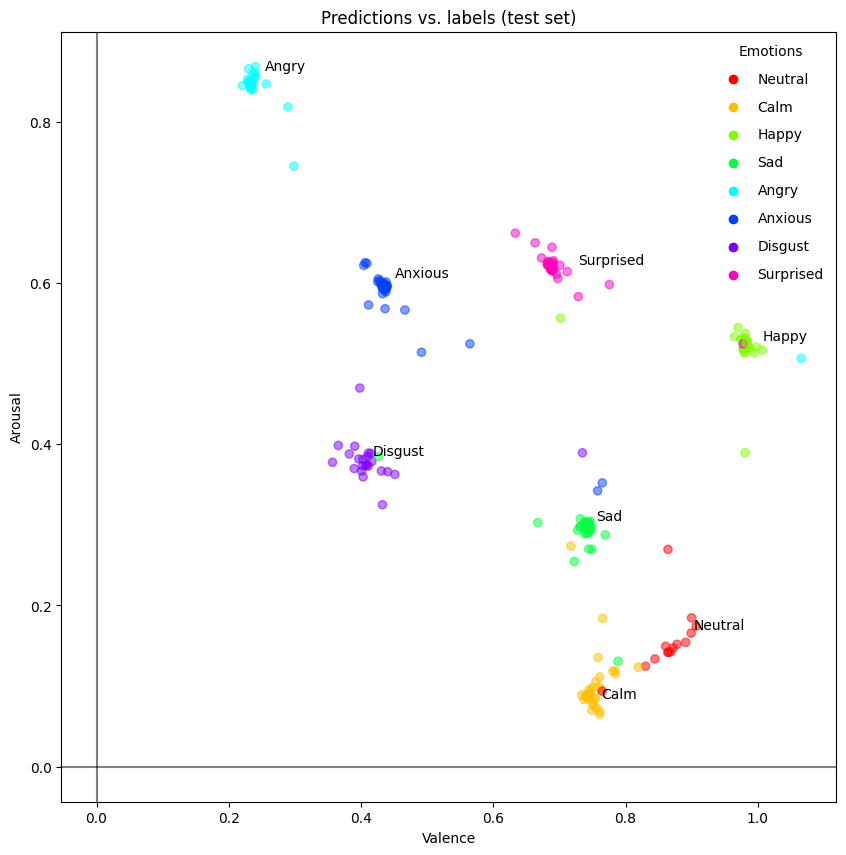

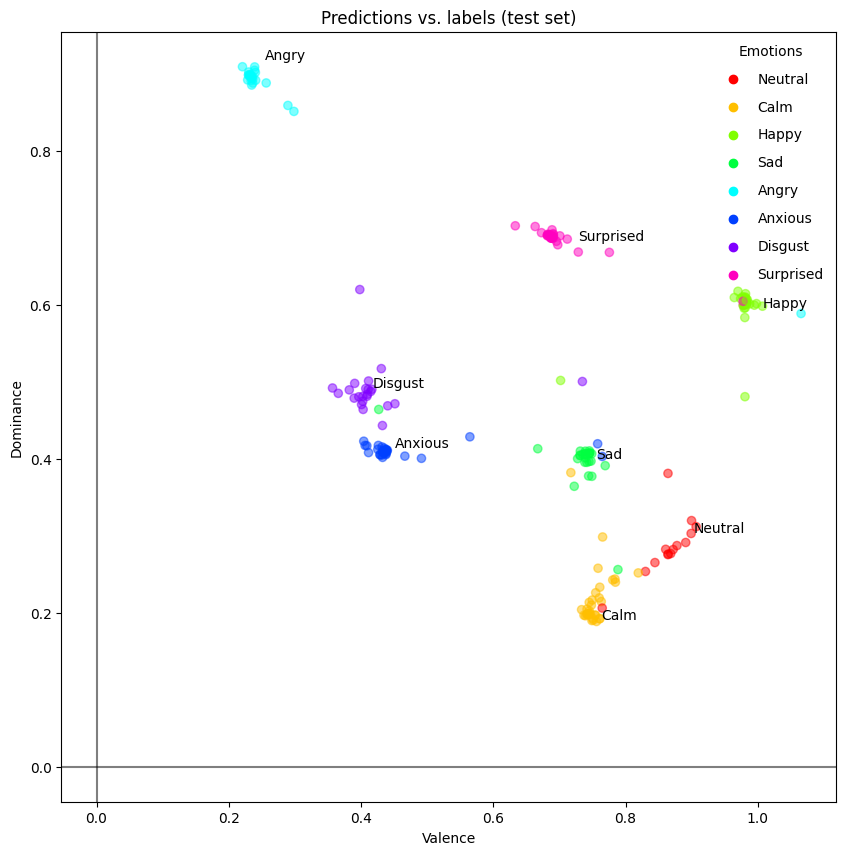

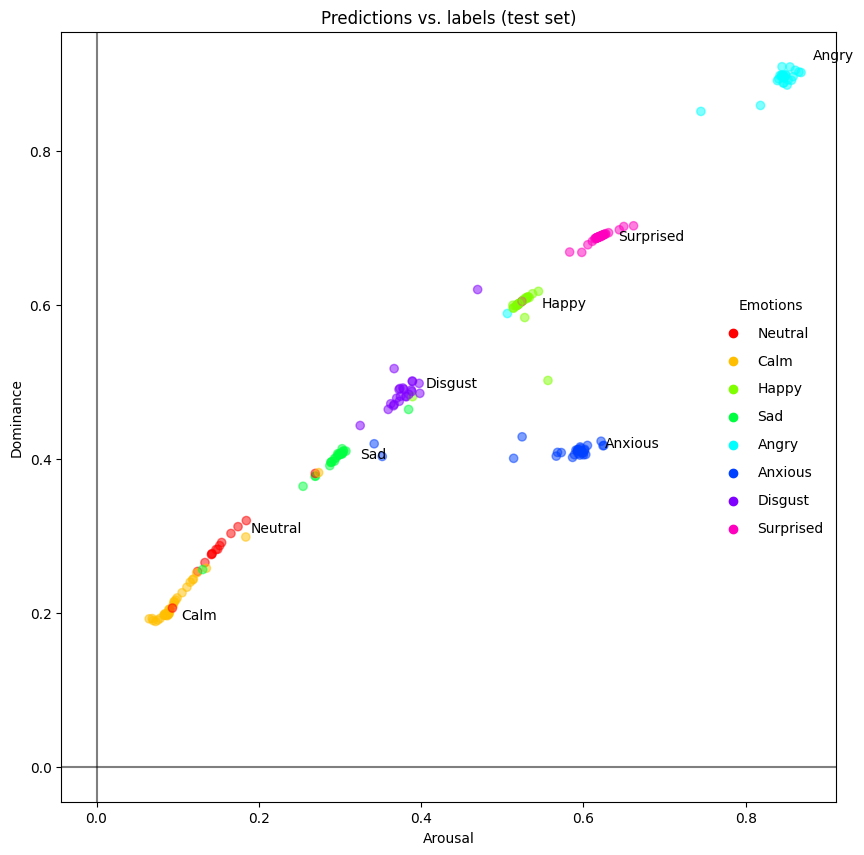

In [72]:

#now lets visualize the predictions on 2d scale. put one blue dot for label coordinate and red dot for prediction coordinate and put a line between them
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

pairs = [["Valence", "Arousal", 0, 1], ["Valence", "Dominance", 0, 2], ["Arousal", "Dominance", 1, 2]]
def closest(x):
    c = '0'
    cd = 10000
    for labelInt in emotion_to_vad_generated:
        label = emotion_to_vad_generated[labelInt]
        d = np.sqrt(np.sum((x - label) ** 2))
        if d < cd:
            c = labelInt
            cd = d
    return label_conversion[c]

# generate random colors for each emotion
colors = {}
for i,labelInt in enumerate(emotion_to_vad_generated):
    colors[label_conversion[labelInt]] = distinct_colors_with_alpha[i]
print(colors)
model.eval()
all_preds1 = []
all_labels1 = []


with torch.no_grad():
    for features, va_labels in test_loader:
        if torch.cuda.is_available():
            features, va_labels = features.cuda(), va_labels.cuda()

        preds = model(features)
        all_preds1.append(preds.cpu().numpy())
        all_labels1.append(va_labels.cpu().numpy())

all_preds1 = np.concatenate(all_preds1)
all_labels1 = np.concatenate(all_labels1)
emo_labels = [closest(label) for label in all_labels1]
emo_labels_colors = list(map(lambda x: colors[x], emo_labels))
for pair in pairs:
    plt.figure(figsize=(10, 10))
    plt.title("Predictions vs. labels (test set)")
    plt.xlabel(pair[0])
    plt.ylabel(pair[1])
    #anotate each label point with emotion above it
    alreadyAnotated = []
    for i in range(len(all_labels1)):
        if emo_labels[i] in alreadyAnotated:
            continue
        alreadyAnotated.append(emo_labels[i])
        plt.annotate(emo_labels[i], (all_labels1[i, pair[2]] + 0.02, all_labels1[i, pair[3]]))

    plt.scatter(all_preds1[:, pair[2]], all_preds1[:, pair[3]],  c=emo_labels_colors, alpha=0.5)

    plt.axhline(0, c="k", alpha=0.5)
    plt.axvline(0, c="k", alpha=0.5)
    completeMisslabeleCount = 0
    for i in range(len(all_labels1)):
        predX, predY, _ = all_preds1[i]
        labelX, labelY, _ = all_labels1[i]

        if (closest(all_preds1[i]) != closest(all_labels1[i])):
            completeMisslabeleCount += 1
        else:
            continue

    print("Completely misslabeled: ", completeMisslabeleCount / all_labels1.shape[0] * 100, "%")

    for label in colors:
        plt.scatter([], [], c=colors[label], label=label)
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Emotions')


In [59]:
# save model
#torch.save(model.state_dict(), "model.pth")

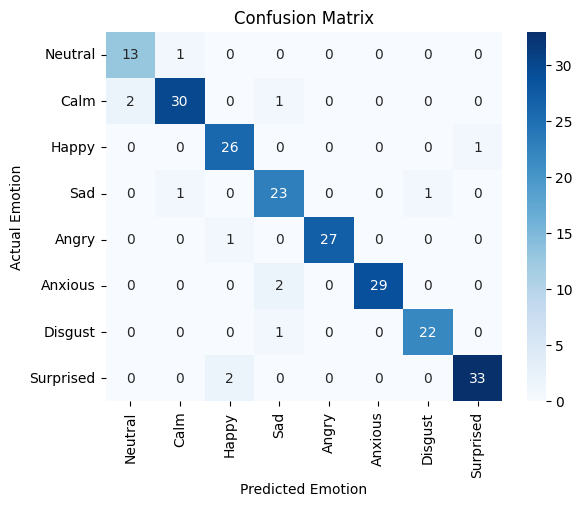

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#classify emotions with closest distance
trueLabels = []
predictedLabels = []
for i in range(len(all_labels1)):
        predX, predY, _ = all_preds1[i]
        labelX, labelY, _ = all_labels1[i]
        trueLabels.append(closest(all_labels1[i]))
        predictedLabels.append(closest(all_preds1[i]))
        
cm = confusion_matrix(trueLabels, predictedLabels, labels=list(label_conversion.values()), )

sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=list(label_conversion.values()), yticklabels=list(label_conversion.values()))
plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.title('Confusion Matrix')
plt.show()